# Homework 2 - Deep Learning Winter 2024 - Question 2
TA: Jerry Abu Ayoub

<font color='aqua'>
Student 1: Or Dinar 207035809
</font>
<br>
<font color='aqua'>
Student 2: Ramiz Srour 314855446
</font>

In [10]:
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
%cd /content/drive/MyDrive/HW2/

/content/drive/MyDrive/תרגילי בית 2025/למידה עמוקה/HW2


In [12]:
!ls

data  HW2.ipynb  Sol_Q2.ipynb  Test


### Pre-Processing the data

This code snippet puts all images in directories corresponding to their label. <font color='red' >**Do not run it if they are already in their directories.**</font>

In [ ]:
import os

# Define the classes
classes = ['cloudy', 'rain', 'shine', 'sunrise']

# Create subdirectories for each class if they don't exist
for cls in classes:
    os.makedirs(os.path.join("Test", cls), exist_ok=True)

# Move files to their respective class subdirectories
for file_name in os.listdir("Test"):
    file_path = os.path.join("Test", file_name)
    if os.path.isfile(file_path):
        for cls in classes:
            if cls in file_name:
                os.rename(file_path, os.path.join("Test", cls, file_name))
                break

### Train

<font color='aqua'>We decided to use dataloaders from previous experience with loading images into memory. Dataloaders provide an easy workflow to process the data sets</font>

In [13]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # Normalize (Imagenet stats for the pretrained model)
])

# Load the dataset
dataset = datasets.ImageFolder("data/", transform=transform)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Load the test dataset
test_dataset = datasets.ImageFolder("Test/", transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

<font color='aqua'>Display 5 random images</font>

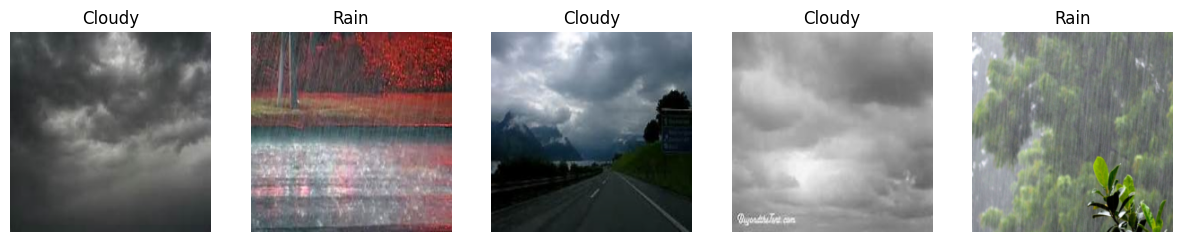

In [14]:
class_names = dataset.classes

# Displays images from data_loader
def show_images(data_loader, num_images=5):
    # Get a batch of images and labels
    images, labels = next(iter(data_loader))

    # Select random indices
    indices = random.sample(range(len(images)), num_images)
    selected_images = [images[i] for i in indices]
    selected_labels = [labels[i] for i in indices]

    # Create a figure to show images
    _, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, (image, label) in enumerate(zip(selected_images, selected_labels)):
        image = image.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C) for display
        image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        image = image.clamp(0, 1)  # Clip values to the range [0, 1]
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(class_names[label.item()])

    plt.show()

# Show 5 random images from test_loader
show_images(test_loader)


<font color='aqua'>The custom loss function implementation</font>

In [15]:
class MyLossFunction(nn.Module):
    def __init__(self):
        super(MyLossFunction, self).__init__()

    def forward(self, logits, labels):
        # Manually compute softmax
        exp_logits = torch.exp(logits)
        softmax = exp_logits / exp_logits.sum(dim=1, keepdim=True)

        # Compute log-softmax for stable computation of cross-entropy
        log_softmax = torch.log(softmax + 1e-12)  # Add epsilon to avoid log(0)

        # Convert labels to one-hot if needed
        one_hot_labels = nn.functional.one_hot(labels, num_classes=logits.size(1)).float()

        # Compute cross-entropy loss
        loss = -torch.sum(one_hot_labels * log_softmax, dim=1).mean()
        return loss

Firstly, we computed softmax for the logits (in this case, the predicted outputs) using the softmax function:
$$ \frac{e^{z_i}}{\sum_{j=1}^{K}e^{z_j}}  $$
After applying log to the softmax we one-hot encoded the labels and then applied the custom loss.

In our custom loss function we implemented cross entropy loss.
* $N$ - the number of samples in a batch (we used 32).
* $X$ - the number classes (4).
* $y_i \in \{0,1\}$ - is the one-hot encoded true label for sample i, where $i\in\{0,1,2,...,N\}$
* $\hat{p}_i$ - the predicted probability vector for the $i$ sample (softmax).
* $\hat{p}_i,j$ - the predicted probability for the $j$ class in the $i$ sample.

Cross Entropy Loss
<font color='aqua'>
$$ \mathcal{L} = - \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{i,j} \log(\hat{p}_{i,j}) $$
</font>
For every sample in a batch, iterate over all classes and compute the entropy.

In [16]:
# Used a pretrained resnet18 model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Modify the final layer for 4 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)

# use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = MyLossFunction()
optimizer = optim.Adam(model.parameters(), lr=0.001)

<font color='aqua'>This block trains the model, we chose to run it for 10 epochs since it achieved convergence within this limit</font>

In [17]:
# Training loop
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

# Validation loop
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training process
epochs = 10
for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/10, Train Loss: 0.4222, Train Accuracy: 85.92%, Val Loss: 2.2258, Val Accuracy: 75.12%
Epoch 2/10, Train Loss: 0.1866, Train Accuracy: 93.66%, Val Loss: 0.7469, Val Accuracy: 80.75%
Epoch 3/10, Train Loss: 0.1358, Train Accuracy: 95.07%, Val Loss: 0.3910, Val Accuracy: 91.08%
Epoch 4/10, Train Loss: 0.1716, Train Accuracy: 95.07%, Val Loss: 0.1760, Val Accuracy: 95.31%
Epoch 5/10, Train Loss: 0.1741, Train Accuracy: 93.90%, Val Loss: 0.3227, Val Accuracy: 93.90%
Epoch 6/10, Train Loss: 0.1188, Train Accuracy: 96.01%, Val Loss: 0.1485, Val Accuracy: 96.71%
Epoch 7/10, Train Loss: 0.1222, Train Accuracy: 95.31%, Val Loss: 0.2780, Val Accuracy: 91.55%
Epoch 8/10, Train Loss: 0.1650, Train Accuracy: 94.95%, Val Loss: 0.1876, Val Accuracy: 95.77%
Epoch 9/10, Train Loss: 0.1092, Train Accuracy: 96.24%, Val Loss: 0.2191, Val Accuracy: 94.84%
Epoch 10/10, Train Loss: 0.0581, Train Accuracy: 97.89%, Val Loss: 0.1073, Val Accuracy: 97.65%


<font color='aqua'>Plot the training graph with accuracies and losses of both training and validation</font>

In [18]:
def plt_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss plot')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy plot')
    plt.legend()

    plt.show()

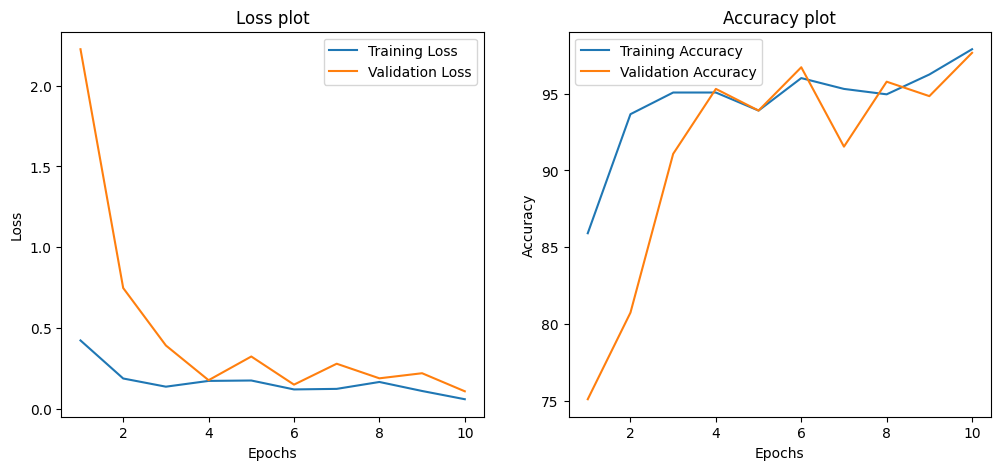

In [19]:
plt_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs)

### Test + Visualization

<font color='aqua'>Function implementation to test the data, plot the confusion matrix, and provide 5 random iamges, their labels and their predictions</font>

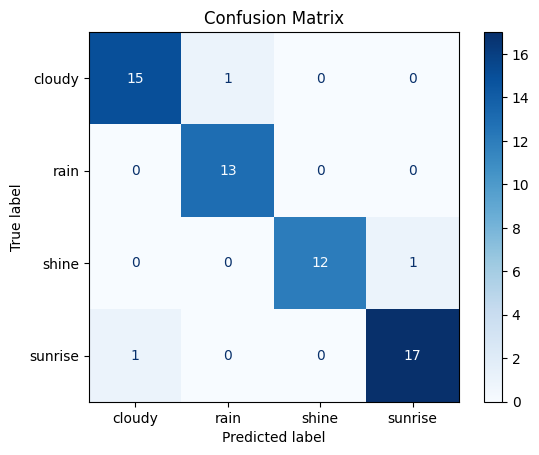

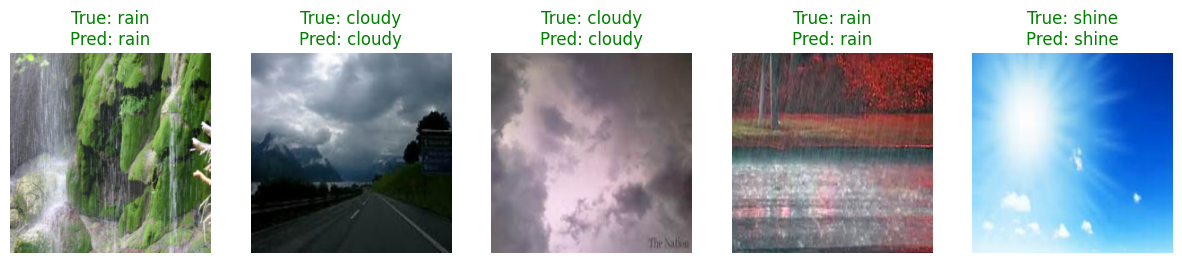

Test Accuracy: 95.00%
Total images tested: 60


In [20]:
def test_with_confusion_matrix_and_predictions(model, test_loader, device, num_images=5):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    sample_images = []
    sample_true_labels = []
    sample_predicted_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            # Collect images, true labels, and predictions for visualization
            if len(sample_images) < num_images:
                sample_indices = random.sample(range(len(images)), min(num_images - len(sample_images), len(images)))
                sample_images.extend(images[sample_indices].cpu())
                sample_true_labels.extend(labels[sample_indices].cpu())
                sample_predicted_labels.extend(predicted[sample_indices].cpu())

    # Calculate accuracy
    accuracy = 100 * correct / total

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_loader.dataset.classes)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot random image predictions
    class_names = test_loader.dataset.classes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, (image, true_label, pred_label) in enumerate(zip(sample_images, sample_true_labels, sample_predicted_labels)):
        img = image.numpy().transpose(1, 2, 0)  # Convert to HWC format for display
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize the default numpy transform
        img = np.clip(img, 0, 1)  # Clip values to range [0, 1]

        axes[i].imshow(img)
        axes[i].axis('off')
        true_label_name = class_names[true_label.item()]
        pred_label_name = class_names[pred_label.item()]
        color = 'green' if true_label_name == pred_label_name else 'red'
        axes[i].set_title(f'True: {true_label_name}\nPred: {pred_label_name}', color=color)

    plt.show()

    return accuracy, total

test_accuracy, total = test_with_confusion_matrix_and_predictions(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Total images tested: {total}")

<font color='aqua'>We used T-SNE to visualize the test data</font>

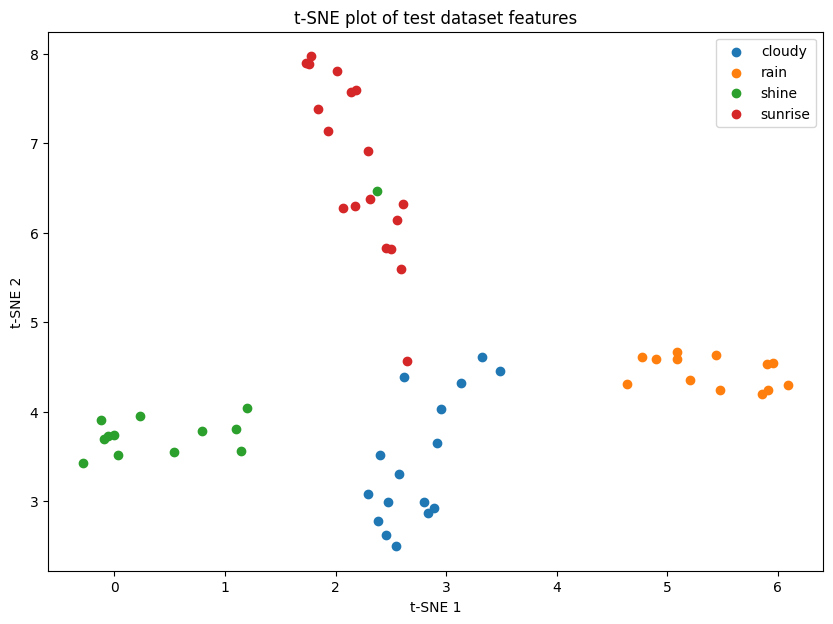

In [21]:
from sklearn.manifold import TSNE

# Function to extract features using the model
def extract_features(model, loader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in loader:
            images = images.to(device)
            outputs = model(images)
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features from the test dataset
test_features, test_labels = extract_features(model, test_loader, device)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(test_features)

# Plot t-SNE results
plt.figure(figsize=(10, 7))
for i, label in enumerate(test_loader.dataset.classes):
    indices = test_labels == i
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=label)
plt.legend()
plt.title('t-SNE plot of test dataset features')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [25]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
print("The layers in this model (ResNET18):")
for name, layer in model.named_children():
    print(name)

Total number of parameters: 11178564
The layers in this model (ResNET18):
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


<font color='aqua'>For more information about layers and their inner layers we printed the model itself</font>

In [24]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  